# TRAINING

In [124]:
import pandas as pd
print('pandas', pd.__version__)

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_validate, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn import __version__
print('sklearn', __version__)

import statsmodels as sm_
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.graphics.tsaplots as sgt

print('statsmodels', sm_.__version__)

import numpy as np
print('numpy', np.__version__)

import keras
print('keras', keras.__version__)

import pickle
print('pickle', pickle.format_version)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib', matplotlib.__version__)

import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor
print('gplearn:', gpl.__version__)

import math 
import os
import random

import arch
from arch import arch_model
print('arch', arch.__version__)

import tensorflow as tf
print('tensorflow', tf.__version__)
from keras import backend as K
from tensorflow.keras import initializers

import utils

pandas 1.3.5
sklearn 1.1.1
statsmodels 0.13.2
numpy 1.21.4
keras 2.9.0
pickle 4.0
matplotlib 3.5.1
gplearn: 0.4.2
arch 5.2.0
tensorflow 2.9.1


In [2]:
# Fisso il Random State per tutto il codice
RANDOM_STATE = 0

# Cross Validation Modelli Statistici

In [3]:
def cross_validation(model, kwargs, df, target, f_exog, n_splits):
    
    '''
    Questa funzione definisce la Cross Validation per i modelli statistici. L'obiettivo del progetto è prevedere i dati
    con una settimana di anticipo e quindi i modelli devono essere valutati solo calcolando l'errore di questa previsione.
    Ma i modelli statistici possono prevedere un intervallo. Noi abbiamo deciso, per ogni modello statistico, di prevedere un 
    intervallo di sette giorni successivo alla fine dei dati di train. La valutazione viene però fatta calcolando l'errore 
    (in questo caso MSE), solo tra la previsione del settimo giorno e i valori veri al settimo giorno. 
    Applicare una cross validation per le serie in questo caso significa, ad ogni passo, shiftare/spostare in avanti il train,
    allungandolo oppure lasciandolo con una lunghezza predefinita, poi dall'ultimo giorno di train prevedere una settimana, 
    ed infine calcolare l'errore al settimo giorno e poi ripetere. Alla fine l'errore finale del modello è la media di tutti 
    gli errori calcolati.
    Con MSE si intende l'errore quadratico medio, che nel caso di un'unica osservazione corrisponde al 
    quadrato della differenzatra i due valori.
    input:
    model: modello che si vuole applicare, può essere 'Sarimax' o 'UCM'
        -kwargs: argomenti per il modello, che quindi dipendono dal modello scelto all'input precedente
        -df: dataset con gli attributi e la colonna da prevedere
        -target: colonna da prevedere, in questo caso 'Livello_Acqua' o 'Portata_Uscita'
        -f_exog: lista contenente i nomi degli attributi esterni che si vogliono utilizzare nel modello
        -n_splits: numero intero che rappresenta il numero di passi che si vogliono effettuare

    output:
        -erore finale ottenuto con la cross validation

    '''

# mse è il vettore in cui salviamo, a ogni passo, il valore dell'errore 
    mse = []
    
    # X è il dataset contenente gli attributi esterni
    X = df[f_exog]
    # Y è la variabile target
    Y = df[target]
    
    # Come gia' scritto, il modello a cui si applica questa cross validation puo' essere Sarimax o UCM
    assert (model == 'Sarimax')
        
    # Definiamo una cv per serie temporali, il numero di splits e' quello di input
    # La dimensione del test size e' una settimana, cioe' sette osservazioni
    time_series_cv = TimeSeriesSplit(n_splits = n_splits, test_size = 7, )
    
    # Per ogni divisione/coppia train e validation
    for train_index, val_index in time_series_cv.split(X):
        
        # Separiamo gli attributi per il train e il validation
        X_train, X_val = X.loc[train_index], X.loc[val_index]
        
        # Separiamo la variabile da prevedere tra train e validation
        Y_train, Y_val = Y[train_index], Y[val_index]
    
    
        if model == 'Sarimax':
            # Se il modello e' Sarimax, definiamo il modello
            # Y_train è la serie obiettivo
            # exog il dataset con variabili esterne
            # Poi fittiamo con metodo di convergenza di Nelder-Mead e un massimo di iterazioni alto per raggiungere convergenza
            model_s = SARIMAX(Y_train, exog = X_train, **kwargs).fit(method = 'nm', maxiter = 11000, disp = False) 
        
        # Lunghezza e' la lunghezza del train
        # Serve per definire gli indici
        lunghezza = len(X_train)
        
        # Otteniamo le previsioni del modello per sette giorni utilizzando anche le variabili esterne del Validation
        predictions = model_s.get_forecast(steps = 7, exog = X_val)
        # Le previsioni sono sotto l'indice 'predict_mean'
        predictions = np.exp(predictions.predicted_mean)
        Y_val = np.exp(Y_val)
        # Calcoliamo l'errore e lo appendiamo
        # Indice e': dalla fine del train aggiungo 6. Perche': se il train ha lunghezza t, l'ultimo indice e' t-1 (perche' 
        # il primo e' zero), allora il validation parte da t, poi t+1, fino a t+6 (che e' il settimo valore)
        mse.append((Y_val[lunghezza+6]-predictions[lunghezza+6])**2)

    # Output e' la media degli errori
    return np.mean(mse)

# Regressione Lineare (modello baseline)

In [4]:
# Attributi per la cross validation
n_split = 60
test_size = 50

## Livello Acqua

In [5]:
# Carico il dataset con attributi normalizzati
X = pd.read_pickle('###')
df_reg_livello = X[X.columns.difference(['Log_Livello_Acqua','Data','Year', 'Time', 'Time_square', 'Intercetta', 'cc_1', 'cc_2', 'ss_1', 'ss_2'])]
df_reg_livello.head()

,Livello_Acqua,Pioggia_Totale,Portata_Uscita,Temperatura_Zona_5
0,30.49,-0.391247,-0.562852,-1.164693
1,30.52,-0.391247,-0.562852,-1.460430
2,30.53,-0.391247,-0.562852,-1.813872
3,30.55,-0.385787,-0.562852,-1.972560
4,30.58,-0.391247,-0.562852,-1.777807


In [6]:
# Escludo dagli attributi le colonne riguardanti la Data e l'anno della misurazione
# Oltre che la colonna target e il suo logaritmo
X_reg_livello = df_reg_livello[df_reg_livello.columns.difference(['Livello_Acqua'])]
# Rappresenta il target
Y_reg_livello = df_reg_livello['Livello_Acqua']

In [7]:
%%time  
# Separazione train-validation con time series cross validation
time_series_cv = TimeSeriesSplit(n_splits = n_split, test_size = test_size)
# Array che memorizza gli errori di ogni passo
MSE_reg_livello = []
    
for train_index, val_index in time_series_cv.split(X_reg_livello):
    # Separazione Train e Validation
    X_train, X_val = X_reg_livello.loc[train_index], X_reg_livello.loc[val_index]
    Y_train, Y_val = Y_reg_livello[train_index], Y_reg_livello[val_index]
    
    # Definisco la Regressione Ridge
    regr = Ridge()
    # Fit e previsioni
    regr.fit(X_train, Y_train)
    y_pre = regr.predict(X_val)
    # Calcolo dell'errore quadratico medi0
    MSE_reg_livello.append(mean_squared_error(Y_val, y_pre))
    
# Print della media degli errori 
round(np.mean(np.array(MSE_reg_livello)),3)

Wall time: 232 ms


5.172

## Training del Modello

In [8]:
%%time
# Definisco la Regressione Ridge
regr_livello = Ridge()
# Fit 
regr_livello = regr_livello.fit(X_reg_livello, Y_reg_livello)

Wall time: 2.64 ms


In [9]:
# Salviamo modello
with open('###', 'wb') as file:
    pickle.dump(regr_livello, file)

## Portata Uscita

In [10]:
# Carico il dataset con attributi normalizzati
X = pd.read_pickle('###', compression='zip')
df_reg_portata = X[X.columns.difference(['Log_Portata_Uscita','Data','Year', 'Time', 'Intercetta', 'Livello_Acqua_square', 'cc_1', 'ss_1', 'cc_2', 'ss_2'])]
df_reg_portata.head()  

,Livello_Acqua,Pioggia_Totale,Portata_Uscita,Temperatura_Zona_5
0,0.745450,-0.391247,0.5,-1.164693
1,0.776161,-0.391247,0.5,-1.460430
2,0.806873,-0.391247,0.5,-1.813872
3,0.815647,-0.385787,0.5,-1.972560
4,0.837584,-0.391247,0.5,-1.777807


In [11]:
# Escludo dagli attributi le colonne riguardanti la Data e l'anno della misurazione
# Oltre che la colonna target e il suo logaritmo
X_reg_portata = df_reg_portata[df_reg_portata.columns.difference(['Portata_Uscita'])]
# Rappresenta il target
Y_reg_portata = df_reg_portata['Portata_Uscita']

In [12]:
%%time
# Separazione train-validation con time series cross validation
time_series_cv = TimeSeriesSplit(n_splits = n_split, test_size = test_size)
# Array che memorizza gli errori di ogni passo
MSE_reg_portata = []
    
for train_index, val_index in time_series_cv.split(X_reg_portata):
    # Separazione Train e Validation
    X_train, X_val = X_reg_portata.loc[train_index], X_reg_portata.loc[val_index]
    Y_train, Y_val = Y_reg_portata[train_index], Y_reg_portata[val_index]
    
    # Definisco la Regressione Lineare
    regr = LinearRegression()
    # Fit e previsioni
    regr.fit(X_train, Y_train)
    y_pre = regr.predict(X_val)
    # Calcolo dell'errore quadratico medi0
    MSE_reg_portata.append(mean_squared_error(Y_val, y_pre))
    
# Print della media degli errori 
round(np.mean(np.array(MSE_reg_portata)),3)

Wall time: 258 ms


17.292

## Training del modello

In [13]:
%%time  
# Definisco la Regressione Lineare
regr_portata = LinearRegression()
# Fit 
regr_portata = regr_portata.fit(X_reg_portata, Y_reg_portata)

Wall time: 4 ms


In [14]:
# Salviamo modello
with open('###', 'wb') as file:
    pickle.dump(regr_portata, file)

# ARIMAX

## Livello Acqua

In [15]:
# Carichiamo dataset e selezione colonne necessarie
X = pd.read_pickle('###', compression='zip')
df_sarima_livello = X[X.columns.difference(['Data','Year', 'Portata_Uscita', 'Livello_Acqua'])]
df_sarima_livello

,Intercetta,Log_Livello_Acqua,Pioggia_Totale,Temperatura_Zona_5,Time,Time_square,cc_1,cc_2,ss_1,ss_2
0,1,3.417399,-0.391247,-1.164693,1,1,0.999852,0.999408,0.017202,0.034398
1,1,3.418382,-0.391247,-1.460430,2,4,0.999408,0.997634,0.034398,0.068755
2,1,3.418710,-0.391247,-1.813872,3,9,0.998669,0.994678,0.051584,0.103031
3,1,3.419365,-0.385787,-1.972560,4,16,0.997634,0.990545,0.068755,0.137185
4,1,3.420346,-0.391247,-1.777807,5,25,0.996303,0.985240,0.085906,0.171177
...,...,...,...,...,...,...,...,...,...,...
4808,1,3.426865,-0.391247,-0.760759,4809,23126481,0.501861,-0.496271,0.864948,0.868168
4809,1,3.426540,1.607224,-0.479449,4810,23136100,0.486908,-0.525841,0.873453,0.850583
4810,1,3.424263,1.781953,-0.883382,4811,23145721,0.471812,-0.554788,0.881699,0.831992
4811,1,3.421653,4.353756,-1.135841,4812,23155344,0.456575,-0.583078,0.889685,0.812416


In [16]:
# Applichiamo un modello lineare per poi studiarne i residui
X_sarima = df_sarima_livello[df_sarima_livello.columns.difference(['Log_Livello_Acqua'])]
Y_sarima = df_sarima_livello['Log_Livello_Acqua']
regr_sarima = sm.OLS(Y_sarima, X_sarima)
results_reg_sarima = regr_sarima.fit()

In [17]:
# Risultati
print(results_reg_sarima.summary())

                            OLS Regression Results                            
Dep. Variable:      Log_Livello_Acqua   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     635.6
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:06:18   Log-Likelihood:                 6898.9
No. Observations:                4813   AIC:                        -1.378e+04
Df Residuals:                    4804   BIC:                        -1.372e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercetta             3.3906      0

In [18]:
num_sinusoidi = 2
omega = np.outer(range(1,len(df_sarima_livello)+1), range(1,num_sinusoidi+1)) * 2 * math.pi / (365.25)
cc = np.cos(omega)
ss = np.sin(omega)

t = np.array(range(1,len(df_sarima_livello)+1))
t2 = t**2 

params = results_reg_sarima.params

level = params[0] + t*params[3] + t2*params[4] 

y_features = params[1]*df_sarima_livello['Pioggia_Totale'] + params[2]*df_sarima_livello['Temperatura_Zona_5']

y_seas = cc.dot(params[5:(5+num_sinusoidi)]) + ss.dot(params[(5+num_sinusoidi):])

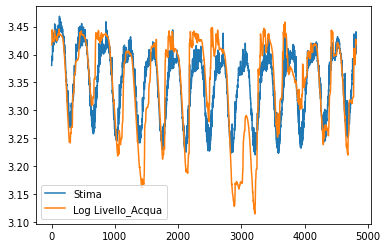

In [19]:
# Plot serie logaritmica e previsione
plt.plot(level+y_features+y_seas, label = 'Stima')
plt.plot(Y_sarima, label = 'Log Livello_Acqua')
plt.legend()
plt.show()
# Ad occhio è un buon risultato tranne nel periodo in cui il Livello ha un periodo di minimo/abbassamento

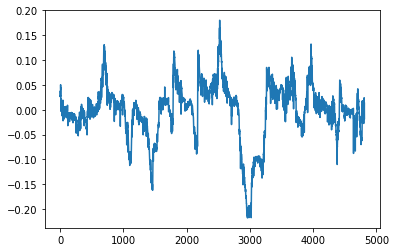

In [20]:
# Plot dei residui
residuals = results_reg_sarima.resid
plt.plot(residuals)
plt.show()

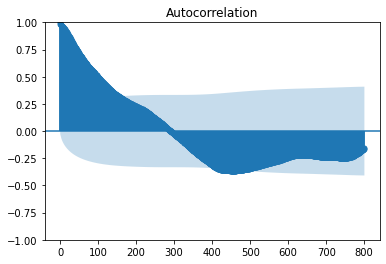

In [21]:
# Acf residui
plot_acf(residuals, lags = 800)
plt.show()

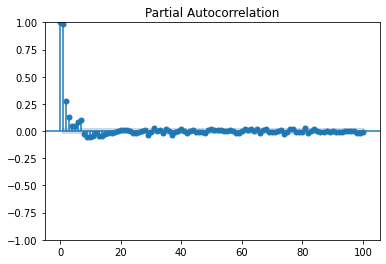

In [22]:
# Pacf residui
plot_pacf(residuals, lags = 100, method = 'ywm')
plt.show()

In [23]:
# Nuovo dataset
X_sarima

,Intercetta,Pioggia_Totale,Temperatura_Zona_5,Time,Time_square,cc_1,cc_2,ss_1,ss_2
0,1,-0.391247,-1.164693,1,1,0.999852,0.999408,0.017202,0.034398
1,1,-0.391247,-1.460430,2,4,0.999408,0.997634,0.034398,0.068755
2,1,-0.391247,-1.813872,3,9,0.998669,0.994678,0.051584,0.103031
3,1,-0.385787,-1.972560,4,16,0.997634,0.990545,0.068755,0.137185
4,1,-0.391247,-1.777807,5,25,0.996303,0.985240,0.085906,0.171177
...,...,...,...,...,...,...,...,...,...
4808,1,-0.391247,-0.760759,4809,23126481,0.501861,-0.496271,0.864948,0.868168
4809,1,1.607224,-0.479449,4810,23136100,0.486908,-0.525841,0.873453,0.850583
4810,1,1.781953,-0.883382,4811,23145721,0.471812,-0.554788,0.881699,0.831992
4811,1,4.353756,-1.135841,4812,23155344,0.456575,-0.583078,0.889685,0.812416


In [24]:
exog = X_sarima[['Pioggia_Totale', 'Temperatura_Zona_5', 'cc_1','ss_1','cc_2','ss_2']]
# Studiamo il modello su tutta la serie
# Poi lo valutiamo applicando la cross validation
model = SARIMAX(Y_sarima, exog = exog, order=(3, 1, 0))

In [25]:
%%time
# fit del modello
model_fit = model.fit(method = 'nm', maxiter = 3000, disp = True) #nm

Optimization terminated successfully.
         Current function value: -4.345149
         Iterations: 288
         Function evaluations: 425
Wall time: 3.82 s


In [26]:
# Residui
residui = model_fit.resid

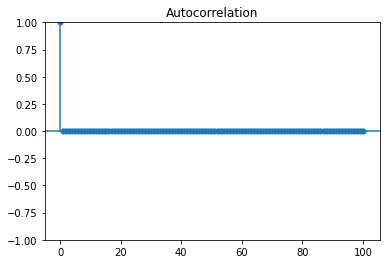

In [27]:
# acf
plot_acf(residui, lags = 100)
plt.show()

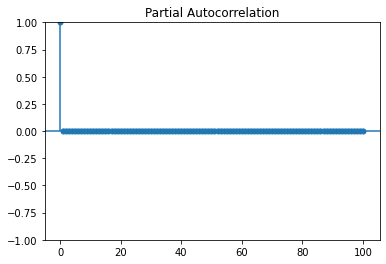

In [28]:
# pacf
plot_pacf(residui, lags = 100, method = 'ywm')
plt.show()

In [29]:
# indici AIC e BIC
print('AIC', model_fit.aic)
print('BIC', model_fit.bic)

AIC -41806.40591163172
BIC -41741.61723086078


In [30]:
# Salvo il modello
model_fit.save('../Models/arima_Livello_Acqua.pkl')

### Cross Validation

In [31]:
# Definizione parametri
Sarima_parametri = {'order' :(3, 1, 0)}
# Senza trend

In [32]:
# Definizione attributi esterni
f_exog = ['Pioggia_Totale', 'Temperatura_Zona_5', 'cc_1','ss_1','cc_2','ss_2']

In [33]:
%%time
# Cross validation
mse_arimax_livello = cross_validation('Sarimax', Sarima_parametri, df_sarima_livello, 'Log_Livello_Acqua', f_exog = f_exog, n_splits = 100)
print('MSE ARIMAX Livello', round(mse_arimax_livello,3))


MSE ARIMAX Livello 0.173
Wall time: 6min 7s


## Portata Uscita

In [159]:
X=pd.read_pickle('###', compression='zip')
df_sarima_portata = X[X.columns.difference(['Data','Year', 'Portata_Uscita'])]
df_sarima_portata

,Intercetta,Livello_Acqua,Livello_Acqua_square,Log_Portata_Uscita,Pioggia_Totale,Temperatura_Zona_5,Time,cc_1,cc_2,ss_1,ss_2
0,1,0.745450,0.555696,-0.693147,-0.391247,-1.164693,0.638961,0.999852,0.999408,0.017202,0.034398
1,1,0.776161,0.602427,-0.693147,-0.391247,-1.460430,0.890577,0.999408,0.997634,0.034398,0.068755
2,1,0.806873,0.651043,-0.693147,-0.391247,-1.813872,0.983028,0.998669,0.994678,0.051584,0.103031
3,1,0.815647,0.665280,-0.693147,-0.385787,-1.972560,0.999254,0.997634,0.990545,0.068755,0.137185
4,1,0.837584,0.701547,-0.693147,-0.391247,-1.777807,0.975687,0.996303,0.985240,0.085906,0.171177
...,...,...,...,...,...,...,...,...,...,...,...
4808,1,0.622606,0.387638,1.945910,-0.391247,-0.760759,0.811273,0.501861,-0.496271,0.864948,0.868168
4809,1,0.622606,0.387638,1.945910,1.607224,-0.479449,0.811151,0.486908,-0.525841,0.873453,0.850583
4810,1,0.605056,0.366093,1.945910,1.781953,-0.883382,0.811030,0.471812,-0.554788,0.881699,0.831992
4811,1,0.626993,0.393120,1.945910,4.353756,-1.135841,0.810908,0.456575,-0.583078,0.889685,0.812416


In [160]:
# Applichiamo un modello lineare per poi studiarne i residui
X_sarima = df_sarima_portata[df_sarima_portata.columns.difference(['Log_Portata_Uscita'])]
Y_sarima = df_sarima_portata['Log_Portata_Uscita']
regr_sarima = sm.OLS(Y_sarima, X_sarima)
results_reg_sarima = regr_sarima.fit()

In [161]:
# Risultati
params = results_reg_sarima.params
print(results_reg_sarima.summary())

                            OLS Regression Results                            
Dep. Variable:     Log_Portata_Uscita   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     550.1
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:50:04   Log-Likelihood:                -4948.1
No. Observations:                4813   AIC:                             9916.
Df Residuals:                    4803   BIC:                             9981.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercetta               0.1145 

In [145]:
num_sinusoidi = 2
omega = np.outer(range(1,len(df_sarima_portata)+1), range(1,num_sinusoidi+1)) * 2 * math.pi / (365.25)
cc = np.cos(omega)
ss = np.sin(omega)

t = np.array(range(1,len(df_sarima_portata)+1))

level = params[0] + params[5]*df_sarima_portata['Time']
y_features = params[1]*df_sarima_portata['Livello_Acqua'] +params[2]*df_sarima_portata['Livello_Acqua_square'] + params[3]*df_sarima_portata['Pioggia_Totale'] +params[4]*df_sarima_portata['Temperatura_Zona_5'] 
y_seas = cc.dot(params[6:(6+num_sinusoidi)]) + ss.dot(params[(6+num_sinusoidi):])


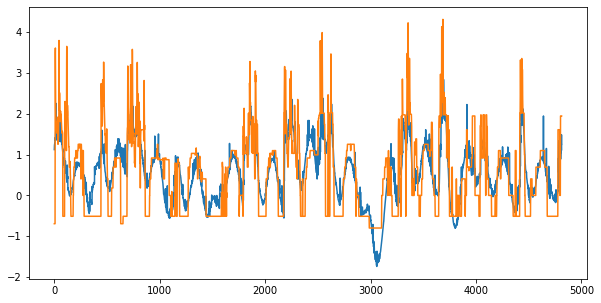

In [146]:
# Serie reale e predetta
plt.plot(level+y_seas+y_features)
plt.plot(Y_sarima)
plt.show()

In [147]:
# Residui
residuals = results_reg_sarima.resid

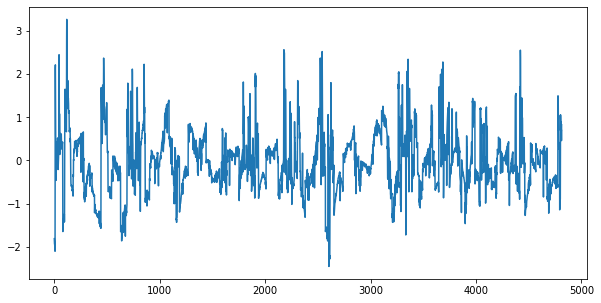

In [148]:
# Plot residui
plt.plot(residuals)
plt.show()

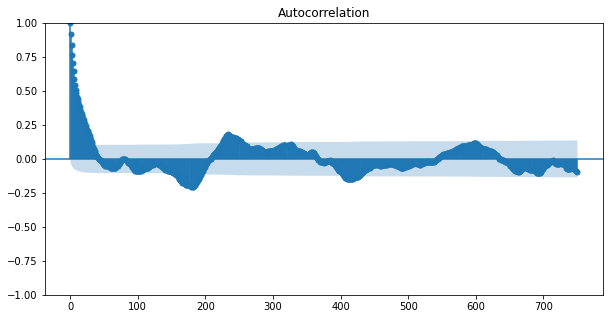

In [149]:
# Acf
plot_acf(residuals, lags = 750)
plt.show()

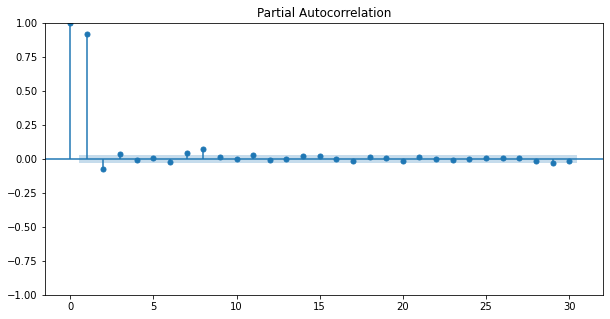

In [150]:
# Pacf
plot_pacf(residuals, lags = 30, method = 'ywm')
plt.show()

In [151]:
# Nuovo dataset
X_sarima.head()

,Intercetta,Livello_Acqua,Livello_Acqua_square,Pioggia_Totale,Temperatura_Zona_5,Time,cc_1,cc_2,ss_1,ss_2
0,1,0.745450,0.555696,-0.391247,-1.164693,0.638961,0.999852,0.999408,0.017202,0.034398
1,1,0.776161,0.602427,-0.391247,-1.460430,0.890577,0.999408,0.997634,0.034398,0.068755
2,1,0.806873,0.651043,-0.391247,-1.813872,0.983028,0.998669,0.994678,0.051584,0.103031
3,1,0.815647,0.665280,-0.385787,-1.972560,0.999254,0.997634,0.990545,0.068755,0.137185
4,1,0.837584,0.701547,-0.391247,-1.777807,0.975687,0.996303,0.985240,0.085906,0.171177


In [152]:
# Attributi esterni
f_exog = [x for x in X_sarima.columns.values if x !='Intercetta']

In [153]:
# Definizione modello
exog = X_sarima[f_exog]
model = SARIMAX(Y_sarima, exog = exog, order=(1, 1, 1))

In [154]:
%%time
# Fit
model_fit = model.fit(method = 'nm', maxiter = 11000, disp = True)


Optimization terminated successfully.
         Current function value: -0.020523
         Iterations: 1444
         Function evaluations: 1996
Wall time: 16.4 s


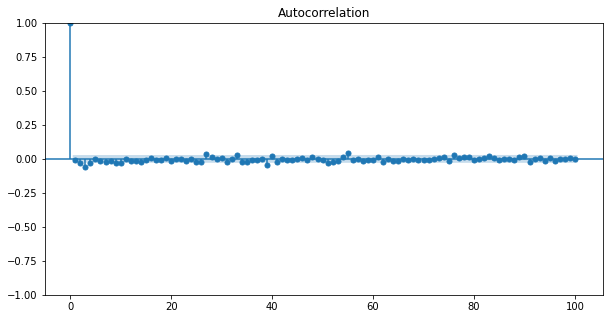

In [155]:
# acf
resid = model_fit.resid
plot_acf(resid, lags = 100)
plt.show()

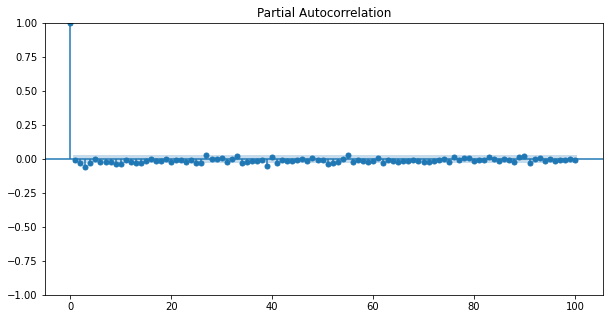

In [156]:
# pacf
plot_pacf(resid, lags = 100, method = 'ywm')
plt.show()

In [157]:
# Indici AIC e BIC
print('AIC', model_fit.aic)
print('BIC', model_fit.bic)

AIC -173.5582861740707
BIC -95.81186924893586


In [158]:
# Salvo il modello
model_fit.save('../Models/arima_Portata_Uscita.pkl')

### Cross Validation

In [51]:
# Parametri
Sarima_parametri = {'order' :(1, 1, 1)}

In [52]:
%%time
# Cross validation
mse_arimax_portata = cross_validation('Sarimax', Sarima_parametri, df_sarima_portata, 'Log_Portata_Uscita', f_exog = f_exog, n_splits = 30)

print('MSE ARIMAX Portata', round(mse_arimax_portata, 3))


MSE ARIMAX Portata 2.67
Wall time: 14min 48s


# Arch

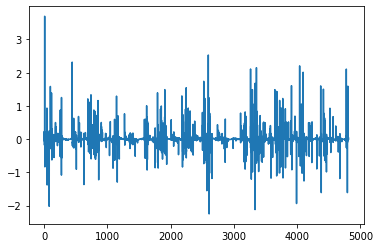

In [53]:
# Plot dei residui
plt.plot(model_fit.resid, label = "Residuals")
plt.show()

# Dai residui sono notano questi picchi che sono in corrispondenza dei picchi della Portata
# che il modello Arima non riesce a prevedere

In [54]:
# Qui dobbiamo fare un lavoro diverso 
len_train = int(80*len(df_sarima_portata)/100)

# Serve esponenziale altrimenti i numeri sono troppo piccoli (e c'e' warning)
train_Y = np.exp(Y_sarima[:len_train])
test_Y = np.exp(Y_sarima[len_train:])

In [55]:
%%time
# Definizione modello e fit
model = SARIMAX(train_Y, order=(1, 1, 1))
model_results = model.fit(method = 'nm', maxiter = 1000, disp = True)

Optimization terminated successfully.
         Current function value: 2.345909
         Iterations: 119
         Function evaluations: 213
Wall time: 1.02 s


In [56]:
# Forecast
arma_forecast = model_results.get_forecast(len(test_Y.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # intervallo di confidenza al 95%

# previsioni
arma_predictions_df["Predictions"] = model_results.predict(start = test_Y.index[0], end = test_Y.index[-1])

# RMSE
arma_rmse = np.sqrt(mean_squared_error(test_Y, arma_predictions_df["Predictions"]))

arma_rmse

3.1903552083656437

In [57]:
arma_predictions_df.head()

,lower Log_Portata_Uscita,upper Log_Portata_Uscita,Predictions
3850,-4.289282,5.620705,0.665711
3851,-5.573035,7.001617,0.714291
3852,-6.245830,7.746242,0.750206
3853,-6.644281,8.197797,0.776758
3854,-6.899148,8.491922,0.796387


In [58]:
# Dataset dei residui
resid_df = pd.DataFrame(
    data = np.exp(Y_sarima),
columns = ['Log_Portata_Uscita'])

resid_df["Log_Portata_resid"] = resid_df["Log_Portata_Uscita"].shift(1).loc[resid_df.index]

resid_df.loc[train_Y.index[0]:train_Y.index[-1]:, "Log_Portata_resid"] = model_results.resid

In [59]:
# Definizione e fit modello GARCH(p, q)
resid_model = arch_model(resid_df["Log_Portata_resid"], p = 10, q = 10, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_Y.index[0], update_freq = 5)
# Summary
resid_model_results.summary()

Iteration:      5,   Func. Count:    125,   Neg. LLF: 7267.989520777828
Iteration:     10,   Func. Count:    245,   Neg. LLF: 86264.67646211469
Iteration:     15,   Func. Count:    365,   Neg. LLF: 5365.588974447498
Iteration:     20,   Func. Count:    486,   Neg. LLF: 5130.441533697861
Iteration:     25,   Func. Count:    602,   Neg. LLF: 4607.155775313136
Iteration:     30,   Func. Count:    737,   Neg. LLF: 5397.456501612046
Iteration:     35,   Func. Count:    869,   Neg. LLF: 12530.065054295905
Iteration:     40,   Func. Count:  1e+03,   Neg. LLF: 4935.906660028701
Iteration:     45,   Func. Count: 1.16e+03,   Neg. LLF: 67295.93369743688
Iteration:     50,   Func. Count: 1.3e+03,   Neg. LLF: 5901.990857311519
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 4607.5223691592855
            Iterations: 55
            Function evaluations: 1326
            Gradient evaluations: 51


C:\Users\maver\AppData\Roaming\Python\Python310\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      Log_Portata_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4607.52
Distribution:                  Normal   AIC:                           9259.04
Method:            Maximum Likelihood   BIC:                           9396.67
                                        No. Observations:                 3850
Date:                Fri, Jun 24 2022   Df Residuals:                     3849
Time:                        22:27:42   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0453  4.846e-02     -0.935      0.350 [ -0.140,4.964e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0385  3.968e-02      0.970      0.332   [-3.928e-02,  0.116]
alpha[1]       0.1991      0.103      1.930  5.362e-02   [-3.106e-03,  0.401]
alpha[2]       0.0461  5.184e-02      0.889      0.374   [-5.554e-02,  0.148]
alpha[3]       0.0890  9.004e-02      0.988      0.323   [-8.749e-02,  0.265]
alpha[4]   1.7356e-07  8.917e-02  1.946e-06      1.000      [ -0.175,  0.175]
alpha[5]       0.0216  4.558e-02      0.474      0.635   [-6.771e-02,  0.111]
alpha[6]   2.3665e-08  7.228e-02  3.274e-07      1.000      [ -0.142,  0.142]
alpha[7]   7.3855e-08  4.547e-02  1.624e-06      1.000 [-8.912e-02,8.912e-02]
alpha[8]   5.0142e-07  1.907e-02  2.629e-05      1.000 [-3.738e-02,3.738e-02]
alpha[9]       0.1976      0.102      1.930  5.364e-02   [-3.096e-03,  0.398]
alpha[10]  2.1891e-08      0.331  6.618e-08      1.000      [ -0.648,  0.648]
beta[1]    5.4715e-08      0.735  7.439e-08      1.000      [ -1.441,  1.441]
beta[2]    6.0626e-08      0.146  4.142e-07      1.000      [ -0.287,  0.287]
beta[3]    6.8484e-08      0.317  2.159e-07      1.000      [ -0.622,  0.622]
beta[4]    5.8165e-08      0.338  1.721e-07      1.000      [ -0.662,  0.662]
beta[5]    4.6392e-08      0.146  3.188e-07      1.000      [ -0.285,  0.285]
beta[6]    4.7721e-08      0.114  4.182e-07      1.000      [ -0.224,  0.224]
beta[7]    1.1881e-07  4.546e-02  2.613e-06      1.000 [-8.910e-02,8.910e-02]
beta[8]        0.0411  3.891e-02      1.056      0.291   [-3.518e-02,  0.117]
beta[9]        0.4056  5.344e-02      7.590  3.200e-14      [  0.301,  0.510]
beta[10]   4.8238e-08      0.488  9.883e-08      1.000      [ -0.957,  0.957]
=============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

In [60]:
resid_forecasts = resid_model_results.forecast(reindex = True).residual_variance.loc[test_Y.index].values

(0.0, 350.0)

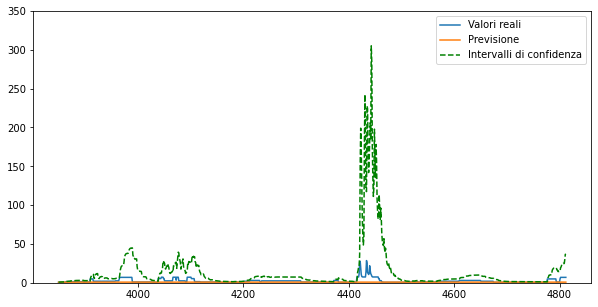

In [61]:
# Nuovi intervalli di confidenza
arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower Portata"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper Portata"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)


# plot
plt.rcParams["figure.figsize"] = 10, 5

# Valori reali
plt.plot(test_Y, label = "Valori reali")
plt.plot(arma_garch_predictions_df["Predictions"][test_Y.index], label = "Previsione")
# intervalli di confidenza
#plt.plot(arma_garch_predictions_df["lower Portata"][test_Y.index], color = "green", linestyle = "--", label = "Intervalli di confidenza")
plt.plot(arma_garch_predictions_df["upper Portata"][test_Y.index], color = "green", linestyle = "--", label = "Intervalli di confidenza")

plt.legend()
plt.plot()
plt.ylim([0, 350])

# VAR (multivariate AR)

In [62]:
# Carichiamo dataset
data = pd.read_pickle('###', compression='zip')
data.dropna(subset=list(data.columns), inplace=True)
data.head()

,Data,Year,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita,cc_1,ss_1,cc_2,ss_2
0,2004-01-02,2004,0.0,6.50,30.21,0.5,0.999852,0.017202,0.999408,0.034398
1,2004-01-03,2004,0.0,4.45,30.28,0.5,0.999408,0.034398,0.997634,0.068755
2,2004-01-04,2004,0.0,2.00,30.35,0.5,0.998669,0.051584,0.994678,0.103031
3,2004-01-05,2004,0.2,0.90,30.37,0.5,0.997634,0.068755,0.990545,0.137185
4,2004-01-06,2004,0.0,2.25,30.42,0.5,0.996303,0.085906,0.985240,0.171177


In [63]:
# Selezione colonne
data_var = data[['Pioggia_Totale', 'Temperatura_Zona_5','Livello_Acqua','Portata_Uscita']]
data_var.head()

,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,0.0,6.50,30.21,0.5
1,0.0,4.45,30.28,0.5
2,0.0,2.00,30.35,0.5
3,0.2,0.90,30.37,0.5
4,0.0,2.25,30.42,0.5


In [64]:
# Test per la Granger Causality
# Le righe sono la variabile risposta, le colonne i predittori. 
# I valori nella tabella sono i P-value, che se sono piu' bassi di 0.05 (soglia), implica 
# che l'ipotesi nulla, cioe' che X (riga) non causa Y (colonna), puo' essere rigettata

maxlag = 7
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [65]:
# Matrice di Granger
grangers_causation_matrix(data_var, variables = data_var.columns.values)
# vengono sollevati alcuni warning

C:\Users\maver\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\maver\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\maver\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\maver\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, bu

,Pioggia_Totale_x,Temperatura_Zona_5_x,Livello_Acqua_x,Portata_Uscita_x
Pioggia_Totale_y,1.0000,0.0,0.0265,0.0251
Temperatura_Zona_5_y,0.0005,1.0,0.0000,0.0022
Livello_Acqua_y,0.0000,0.0,1.0000,0.0000
Portata_Uscita_y,0.0000,0.0,0.0000,0.9986


In [66]:
# Le Serie in data devono essere stazionarie per quello uso il log
order_model = VAR(data_var)
x = order_model.select_order(maxlags=10)
x.summary()
# 7 è il risultato migliore

,AIC,BIC,FPE,HQIC
0,15.39,15.39,4.813e+06,15.39
1,4.872,4.899,130.6,4.882
2,4.691,4.740,109.0,4.708
3,4.599,4.669*,99.41,4.624
4,4.579,4.670,97.39,4.611
5,4.569,4.683,96.49,4.609*
6,4.563,4.697,95.83,4.610
7,4.558,4.715,95.43,4.613
8,4.552,4.730,94.84,4.615
9,4.551,4.750,94.69,4.621


In [67]:
%%time
N_rip = 3000
lunghezza = 3000
step = 1
mse_Livello = []
mse_Portata = []
nobs = 7
for i in range(N_rip):
    data_var_cv = data_var[0:(lunghezza+i*step)]
    df_train, df_val = data_var_cv[0:-nobs], data_var_cv[-nobs:]
    var_model = VAR(df_train)
    model_fitted = var_model.fit(7)
    # ordine del lag
    lag_order = model_fitted.k_ar
    

# dati in input per previsione
    forecast_input = df_train.values[-lag_order:]

# Forecast
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    df_forecast = pd.DataFrame(fc, index=data_var_cv.index[-nobs:], columns=data_var.columns.values)
    yhat = df_forecast.tail(1)
    
    
    mse_Livello.append((float(yhat['Livello_Acqua'])-float(df_val.tail(1)['Livello_Acqua']))**2)
    mse_Portata.append((float(yhat['Portata_Uscita'])-float(df_val.tail(1)['Portata_Uscita']))**2)

mse_var_livello = np.mean(mse_Livello)
mse_var_portata = np.mean(mse_Portata)

print('MSE VAR Livello:', round(mse_var_livello, 3))
print('MSE VAR Portata:', round(mse_var_portata, 3))

MSE VAR Livello: 0.126
MSE VAR Portata: 10.602
Wall time: 1min 1s


In [68]:
# Salviamo il modello
with open('../Models/VAR.pkl', 'wb') as file:
    pickle.dump(model_fitted, file)

# Symbolic Regression

## Livello Acqua

In [69]:
# Carichiamo dataset
df_livello = pd.read_pickle('###', compression='zip')
df_livello_symbolic = df_livello[['Pioggia_Totale', 'Temperatura_Zona_5', 'Portata_Uscita','Livello_Acqua']]
df_livello_symbolic.head()

,Pioggia_Totale,Temperatura_Zona_5,Portata_Uscita,Livello_Acqua
0,-0.391247,-1.164693,-0.562852,30.49
1,-0.391247,-1.460430,-0.562852,30.52
2,-0.391247,-1.813872,-0.562852,30.53
3,-0.385787,-1.972560,-0.562852,30.55
4,-0.391247,-1.777807,-0.562852,30.58


In [70]:
# Split train-validation, senza cross validation
df_train_reg_livello, df_val_reg_livello = train_test_split(
    df_livello_symbolic,
    train_size=0.8,
    shuffle=False,
    random_state=RANDOM_STATE
)

In [71]:
# Divisione di attributi e target, per train e per validation set
X_train_reg_livello = df_train_reg_livello[df_train_reg_livello.columns.difference(['Livello_Acqua'])]
X_val_reg_livello = df_val_reg_livello[df_train_reg_livello.columns.difference(['Livello_Acqua'])]
Y_train_reg_livello = df_train_reg_livello['Livello_Acqua']
Y_val_reg_livello = df_val_reg_livello['Livello_Acqua']

In [72]:
# Istanziamo i parametri del modello
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'log']

model_livello = SymbolicRegressor(population_size = 1000,
                          tournament_size = 50,
                          generations = 200,
                          stopping_criteria=0.1,
                          metric='mse',
                          function_set = function_set, 
                          p_crossover=0.65,
                          p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05,
                          p_point_mutation=0.1,
                          verbose = 0,
                          random_state = RANDOM_STATE,
                          n_jobs = -1)

In [73]:
%%time
# Train
model_livello.fit(X_train_reg_livello, Y_train_reg_livello)


# Predict
sr_y_pred_livello = model_livello.predict(X_val_reg_livello).reshape(-1,1)

Wall time: 9min 11s


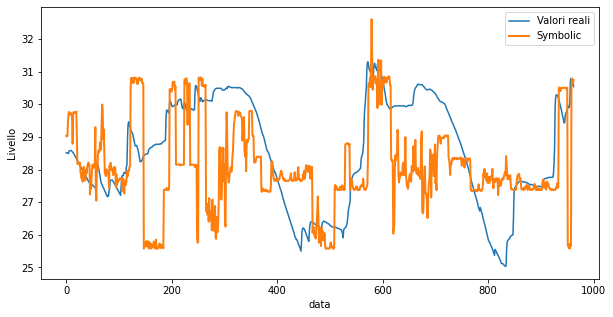

MSE Symbolic regression Livello Acqua: 2.916


In [74]:
# Plot dei risultati
plt.figure()
plt.plot(list(Y_val_reg_livello), label = 'Valori reali')
plt.plot(sr_y_pred_livello, label="Symbolic", linewidth=2)
plt.xlabel("data")
plt.ylabel("Livello")
plt.legend()
plt.show()

# Valore di errore
mse_livello_sybolic = round(mean_squared_error(Y_val_reg_livello, sr_y_pred_livello), ndigits=3)
print('MSE Symbolic regression Livello Acqua:', mse_livello_sybolic)

In [75]:
# Salviamo modello
with open('###', 'wb') as file:
    pickle.dump(model_livello, file)

In [76]:
%%time
# Con Cross validation
time_series_cv = TimeSeriesSplit(n_splits = 15, test_size = 7)
    
MSE_livello = []

X = df_livello_symbolic[df_livello_symbolic.columns.difference(['Livello_Acqua', 'Log_Livello_Acqua','Data','Year'])]
Y = df_livello_symbolic['Livello_Acqua']

for train_index, val_index in time_series_cv.split(X):
    # Divisione train e validation
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    
    
    model = SymbolicRegressor(population_size = 500,
                          tournament_size = 50,
                          generations = 40, # Diminuisco numero di generazioni per diminuire il costo
                          stopping_criteria=0.1,
                          metric='mse',
                          function_set = function_set, 
                          p_crossover=0.65,
                          p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05,
                          p_point_mutation=0.1,
                          verbose = 0,
                          random_state = RANDOM_STATE,
                          n_jobs = -1)
    
    model.fit(X_train, Y_train)

    # Predict
    y_pred = model.predict(X_val).reshape(-1,1)
    
    MSE_livello.append((list(Y_val)[6]-y_pred[6])**2)

Wall time: 6min 5s


In [77]:
# MSE con cross-validation
round(np.mean(np.array(MSE_livello)),3)

1.454

## Portata Uscita

In [78]:
# Carichiamo dataset
df_portata = pd.read_pickle('###', compression='zip')
df_portata_symbolic = df_portata[['Pioggia_Totale', 'Temperatura_Zona_5', 'Livello_Acqua', 'Portata_Uscita']]
df_portata_symbolic.head()

,Pioggia_Totale,Temperatura_Zona_5,Livello_Acqua,Portata_Uscita
0,-0.391247,-1.164693,0.745450,0.5
1,-0.391247,-1.460430,0.776161,0.5
2,-0.391247,-1.813872,0.806873,0.5
3,-0.385787,-1.972560,0.815647,0.5
4,-0.391247,-1.777807,0.837584,0.5


In [79]:
# Definizione parametri
# Viene aggiunta una funzione di partenza personalizzata
def portata_trend( x ):
    a = x + x**2; 
    return a    

portata_trend = gpl.functions.make_function( function = portata_trend, name='trend', arity=1)

function_set = ['add', 'sub', 'mul', 'div', 'sin', portata_trend]

portata_model = SymbolicRegressor(population_size = 1000,
                          tournament_size = 50,
                          generations = 200,
                          stopping_criteria=0.1,
                          metric='mse',
                          function_set = function_set, 
                          p_crossover=0.65,
                          p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05,
                          p_point_mutation=0.1,
                          verbose = 0,
                          random_state = RANDOM_STATE,
                          n_jobs = -1)

In [80]:
# Split train-validation, senza cross validation
df_train_reg_portata, df_val_reg_portata = train_test_split(
    df_portata_symbolic,
    train_size=0.8,
    shuffle=False,
    random_state=RANDOM_STATE
)

X_train_reg_portata = df_train_reg_portata[df_train_reg_portata.columns.difference(['Portata_Uscita'])]
X_val_reg_portata = df_val_reg_portata[df_train_reg_portata.columns.difference(['Portata_Uscita'])]
Y_train_reg_portata = df_train_reg_portata['Portata_Uscita']
Y_val_reg_portata = df_val_reg_portata['Portata_Uscita']

In [81]:
%%time 
# Train
portata_model.fit(X_train_reg_portata, Y_train_reg_portata)

# Predict
sr_y_pred_portata = portata_model.predict(X_val_reg_portata).reshape(-1,1)

Wall time: 10min 53s


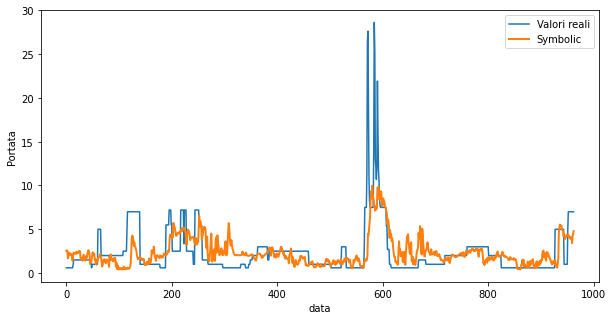

MSE Symbolic regression Portata Uscita: 5.566


In [82]:
# Plot the results
plt.figure()
plt.plot(list(Y_val_reg_portata), label = 'Valori reali')
plt.plot(sr_y_pred_portata, label="Symbolic", linewidth=2)
plt.xlabel("data")
plt.ylabel("Portata")
plt.legend()
plt.show()

# Valore MSE
mse_portata_sybolic = round(mean_squared_error(Y_val_reg_portata, sr_y_pred_portata), ndigits=3)
print('MSE Symbolic regression Portata Uscita:', mse_portata_sybolic)

In [83]:
# Salviamo modello
with open('###', 'wb') as file:
    pickle.dump(portata_model, file)

In [84]:
%%time
# Con Cross validation
time_series_cv = TimeSeriesSplit(n_splits = 10, test_size = 7)
    
MSE = []

X = df_portata_symbolic[df_portata_symbolic.columns.difference(['Portata_Uscita', 'Log_Portata_Uscita','Data','Year'])]
Y = df_portata_symbolic['Portata_Uscita']

for train_index, val_index in time_series_cv.split(X):
    # Divisione train e validation
    X_train, X_val = X.loc[train_index], X.loc[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    
    
    model = SymbolicRegressor(population_size = 300,
                          tournament_size = 50,
                          generations = 30, # Diminuisco numero di generazioni per diminuire il costo
                          stopping_criteria=0.1,
                          metric='mse',
                          function_set = function_set, 
                          p_crossover=0.65,
                          p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05,
                          p_point_mutation=0.1,
                          verbose = 0,
                          random_state = RANDOM_STATE,
                          n_jobs = -1)
    
    model.fit(X_train, Y_train)

    # Predict
    y_pred = model.predict(X_val).reshape(-1,1)
    
    MSE.append((list(Y_val)[6]-y_pred[6])**2)

Wall time: 2min 46s


In [85]:
# MSE
round(np.mean(np.array(MSE)),3)

6.378

# KNN

In [86]:
# Carichiamo dataset
df = pd.read_csv('###')

## Livello

In [87]:
# Scelta colonne
df_livello = df[['Data','Livello_Acqua']]

In [88]:
# Definizione iper-parametri KNN
p = 365*3 # history per la previsione (iperparametro knn)
k = 5 # k (iperparametro knn)
h = 7 # horizon --> siamo in Multi-Step (in particolare multi-output)
N_rip = 2000 # numero di ripeizioni per CV, anche 1000 ripetizioni
step = 1 # step per la cross validation
pesi = 'media'
MSE = []

In [89]:
%%time
# Cross Validation
for rip in range(N_rip):
    stream = np.array(df_livello['Livello_Acqua'])
    t = 365*4 + rip*step
    if t+h>=len(stream):
        break
# Ricerca delle k sotto-sequenze simili alla stream[(t-p):t]
    count = 0
    s = np.array(df_livello['Livello_Acqua'])
    start = t-p
    end = t+1
    query = stream[start:end] # <- la serie query è lunga p+1
    IXS = np.zeros(k)
    
    while count < k:
        d_min = math.inf
        for ix in range(0,(t-p-h+1)):
            subseq = s[ix:(ix+p+1)]
            d = np.linalg.norm(subseq-query)
            if d < d_min:
                d_min = d
                IXS[count] = ix
    
        ind = int(IXS[count])
        count = count + 1
        s[ind:(ind+p+1)] = math.inf # Si assume non sovrapposizione

    IXS = IXS[IXS>0] # <- se non fosse possibile identificare le sotto-sequenze

    # predizione
    futuri = np.empty((len(IXS),h))
    for i in range(0,len(IXS)):
        w = range(int(IXS[i]+p+1),int(IXS[i]+p+h+1))
        futuri[i,:] = stream[w]
        wp = range(int(IXS[i]),int(IXS[i]+p+1))

    # calcolo media o mediana
    if pesi == 'media':
        pred = futuri.mean(0)
    else:
        pred = np.median(futuri, axis=0)
    
    MSE.append((pred[h-1]-stream[t+h])**2 )

Wall time: 2min 2s


In [90]:
# MSE
MSE_mean_livello = np.mean(np.array(MSE))
print('MSE KNN Livello:', round(MSE_mean_livello, 3))

MSE KNN Livello: 1.102


## Portata

In [91]:
# Scelta colonne dal dataset
df_portata = df[['Data','Portata_Uscita']]

In [92]:
# Definizione iper-parametri
p = 365*2 # history per la previsione (iperparametro knn)
k = 5 # k (iperparametro knn)
h = 7 # horizon --> siamo in Multi-Step (in particolare multi-output)
N_rip = 1000 # numero di ripeizioni per CV
step = 1 # step per la cross validation
pesi = 'media'
MSE = []

In [93]:
%%time
# Cross Validation
for rip in range(N_rip):
    stream = np.array(df_portata['Portata_Uscita'])
    t = 365*4 + rip*step
    if t+h>=len(stream):
        break
# Ricerca delle k sotto-sequenze simili alla stream[(t-p):t]
    count = 0
    s = np.array(df_portata['Portata_Uscita'])
    start = t-p
    end = t+1
    query = stream[start:end] # <- la serie query è lunga p+1
    IXS = np.zeros(k)
    
    while count < k:
        d_min = math.inf
        for ix in range(0,(t-p-h+1)):
            subseq = s[ix:(ix+p+1)]
            d = np.linalg.norm(subseq-query)
            if d < d_min:
                d_min = d
                IXS[count] = ix
  
        ind = int(IXS[count])
        count = count + 1
        s[ind:(ind+p+1)] = math.inf # Si assume non sovrapposizione

    IXS = IXS[IXS>0] # <- se non fosse possibile identificare le sotto-sequenze
    
    # predizione
    futuri = np.empty((len(IXS),h))
    for i in range(0,len(IXS)):
        w = range(int(IXS[i]+p+1),int(IXS[i]+p+h+1))
        futuri[i,:] = stream[w]
        wp = range(int(IXS[i]),int(IXS[i]+p+1))
    
    # calcolo media o mediana
    if pesi == 'media':
        pred = futuri.mean(0)
    else:
        pred = np.median(futuri, axis=0)
    
    MSE.append((pred[h-1]-stream[t+h])**2 )

Wall time: 55.2 s


In [94]:
# MSE
MSE_mean_portata = np.mean(np.array(MSE))
print('MSE KNN Portata:', round(MSE_mean_portata, 3))

MSE KNN Portata: 9.785


# Neural Network

In [95]:
# Impostazione di diversi seed per poter garantire la riproducibiltà dei risultati
# vengono anche importati degli ulteriori pacchetti

os.environ['PYTHONHASHSEED']=str(RANDOM_STATE)

random.seed(RANDOM_STATE)

np.random.seed(RANDOM_STATE)

tf.compat.v1.set_random_seed(RANDOM_STATE)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [96]:
print('tensorflow', tf.__version__)

tensorflow 2.9.1


## Portata

In [97]:
# Caricamento dataset
# utilizziamo dataset con dati non normalizzati
df = pd.read_pickle('###', compression='zip')

In [98]:
# Divisione train validation
df_train, df_val = train_test_split(
    df,
    train_size=0.8,
    shuffle=False,
    random_state=RANDOM_STATE
)

In [99]:
# Definizione colonne feature e target
nn_features = ['Temperatura_Zona_5', 'Pioggia_Totale', 'Livello_Acqua']
nn_target = ['Portata_Uscita']

In [100]:
# Separazione di target e feature
X_train = df_train[nn_features]
X_val = df_val[nn_features]

Y_train = df_train[nn_target]
Y_val = df_val[nn_target]

In [101]:
# Viene aggiunta una dimensione per rendere i dataset utilizzabili dalla rete
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [102]:
# Creazione della rete neurale con i diversi layer che la compongono
batch_size = 5

input_layer = keras.Input(shape=(len(nn_features), 1))

lstm_1 = keras.layers.LSTM(units = 100,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True,
             batch_size = batch_size,
             recurrent_initializer='glorot_normal',
             return_sequences = True,
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(input_layer)

lstm_2 = keras.layers.LSTM(units = 50,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True,
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_1)

lstm_3 = keras.layers.LSTM(units = 30,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True,
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_2)

lstm_4 = keras.layers.GRU(units = 10,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True,
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_3)

portata_output = keras.layers.Dense(1, activation = 'relu', name = 'portata_output')(lstm_4)

model = keras.Model(inputs=input_layer, outputs=portata_output)

In [103]:
# Compliazione della rete e scelta di ottimizzatore e funzione di loss
model.compile(
    optimizer="adam",
    loss= {"portata_output": keras.losses.MeanSquaredError()},
    metrics = [keras.losses.MeanSquaredError()])

In [104]:
# Viene istanziato un early stop per evitare di allenare la rete inutilmente
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True
)

callback = []
callback.append(early_stopping_callback)

In [105]:
# Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 3, 50)             30200     
                                                                 
 lstm_2 (LSTM)               (None, 3, 30)             9720      
                                                                 
 gru (GRU)                   (None, 3, 10)             1260      
                                                                 
 portata_output (Dense)      (None, 3, 1)              11        
                                                                 
Total params: 81,991
Trainable params: 81,991
Non-trainable p

In [106]:
%%time
# Fit
train = model.fit(
    x=X_train,
    y={'portata_output': Y_train.Portata_Uscita},
    validation_data = (X_val, {'portata_output' : Y_val.Portata_Uscita}),
    epochs=50,
    batch_size=batch_size,
    callbacks=callback,
    verbose = False,
    shuffle = False)

Wall time: 4min 15s


In [107]:
# numero di epoche di addestramento
print('Addestramento della rete effettuato in', len(train.epoch), 'epoche')
#46

Addestramento della rete effettuato in 46 epoche


In [108]:
train.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

MSE Neural network Portata 8.599


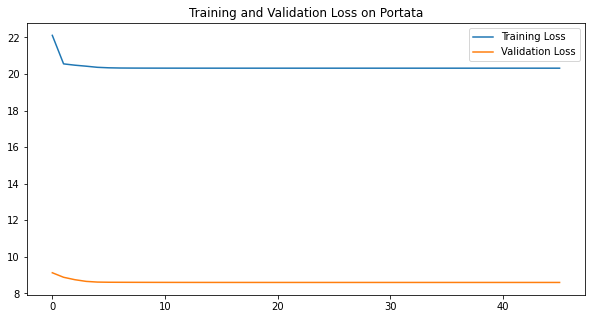

In [109]:
# Risultati
plt.plot(train.history['mean_squared_error'], label='Training Loss')
plt.plot(train.history['val_mean_squared_error'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss on Portata')

mse_portata_nn = round(train.history['val_mean_squared_error'][-1], ndigits=3)

print('MSE Neural network Portata', mse_portata_nn)
#8.599

In [110]:
# Slaviamo il modello
with open('###', 'wb') as file:
    pickle.dump(train, file)

INFO:tensorflow:Assets written to: ram://cafd162e-182a-443a-8cd5-8ea91625bce3/assets


INFO:tensorflow:Assets written to: ram://cafd162e-182a-443a-8cd5-8ea91625bce3/assets


## Livello

In [111]:
# Carichiamo dati normalizzati
df = pd.read_pickle('###', compression='zip')

In [112]:
# Divisione train validation
_train, df_val = train_test_split(
    df,
    train_size=0.8,
    shuffle=False,
    random_state=RANDOM_STATE
)

In [113]:
# Definizione colonne feature e target
nn_features = ['Temperatura_Zona_5', 'Pioggia_Totale', 'Portata_Uscita']
nn_target = ['Livello_Acqua']

In [114]:
# Separazione di target e feature
X_train = df_train[nn_features]
X_val = df_val[nn_features]

Y_train = df_train[nn_target]
Y_val = df_val[nn_target]

In [115]:
# Aggiunta una dimensione
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [116]:
# Creazione della rete neurale con i diversi layer che la compongono
batch_size = 5

input_layer = keras.Input(shape=(len(nn_features), 1))

lstm_1 = keras.layers.LSTM(units = 100,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True, # requirement   
             batch_size = batch_size,
             recurrent_initializer='glorot_normal',
             return_sequences = True,
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(input_layer)

lstm_2 = keras.layers.LSTM(units = 50,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True, # requirement   
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_1)

lstm_3 = keras.layers.LSTM(units = 30,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True, # requirement   
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_2)

lstm_4 = keras.layers.GRU(units = 10,
             activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, unroll=False, use_bias=True, # requirement   
             return_sequences = True,
             recurrent_initializer='glorot_normal',
             kernel_initializer=initializers.RandomNormal(seed = RANDOM_STATE),
             bias_initializer=initializers.Zeros())(lstm_3)

livello_output = keras.layers.Dense(1, activation = 'relu', name = 'livello_output')(lstm_4)

model = keras.Model(inputs=input_layer, outputs=livello_output)

In [117]:
# Compliazione della rete e scelta di ottimizzatore e funzione di loss
model.compile(
    optimizer="adam",
    loss= {"livello_output": keras.losses.MeanSquaredError()},
    metrics = [keras.losses.MeanSquaredError()])

In [118]:
# Early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True
)

callback = []
callback.append(early_stopping_callback)

In [119]:
# Summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 3, 100)            40800     
                                                                 
 lstm_4 (LSTM)               (None, 3, 50)             30200     
                                                                 
 lstm_5 (LSTM)               (None, 3, 30)             9720      
                                                                 
 gru_1 (GRU)                 (None, 3, 10)             1260      
                                                                 
 livello_output (Dense)      (None, 3, 1)              11        
                                                                 
Total params: 81,991
Trainable params: 81,991
Non-trainable

In [120]:
%%time
# Fit
train = model.fit(
    x=X_train,
    y={'livello_output': Y_train.Livello_Acqua},
    validation_data = (X_val, {'livello_output' : Y_val.Livello_Acqua}),
    epochs=50,
    batch_size=batch_size,
    callbacks=callback,
    verbose = False,
    shuffle = False)

Wall time: 1min 17s


In [121]:
# Epoche di addestramento
print('Addestramento della rete effettuato in', len(train.epoch), 'epoche')

Addestramento della rete effettuato in 12 epoche


MSE Neural network Livello 2.765


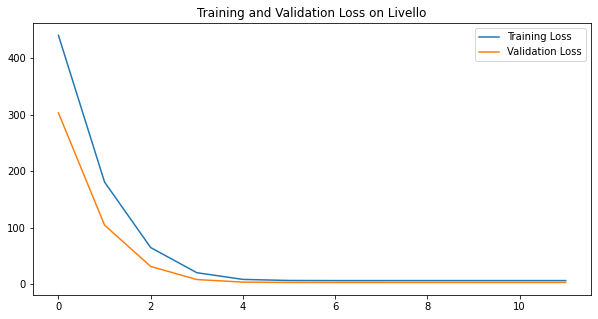

In [122]:
# risultati livello
plt.plot(train.history['mean_squared_error'], label='Training Loss')
plt.plot(train.history['val_mean_squared_error'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss on Livello')

mse_livello_nn = round(train.history['val_mean_squared_error'][-1], ndigits=3)

print('MSE Neural network Livello', mse_livello_nn)
#2.757

In [123]:
# Salviamo il modello
with open('../Models/rete_Livello_Acqua.pkl', 'wb') as file:
    pickle.dump(train, file)

INFO:tensorflow:Assets written to: ram://0cf7b199-ecaf-42bc-bbf7-cb3de622b6c8/assets


INFO:tensorflow:Assets written to: ram://0cf7b199-ecaf-42bc-bbf7-cb3de622b6c8/assets
